In [ ]:
!pip install wfdb

In [ ]:
pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 28.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [ ]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.1


# 1- Upload MIT-BIH Arrhythmia database

## 1.1- Pair with Drive

In [ ]:
from google.colab import drive
import zipfile

drive.mount('/content/gdrive')

zip_path = '/content/gdrive/MyDrive/mit-bih-arrhythmia-database-1.0.0.zip'
extract_dir = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 1.2- Upload Data in a dictionary

In [ ]:
import wfdb
import os

data_dir = '/content/mit-bih-arrhythmia-database-1.0.0'

# Get a list of all the record names in the directory
records = [os.path.splitext(f)[0] for f in os.listdir(data_dir) if f.endswith('.dat')]

# Sort the records based on the record number
records.sort(key=int)

ecg_signals = {}

for record_name in records:
    # Read the record
    record = wfdb.rdrecord(os.path.join(data_dir, record_name))
    # Store the whole signal in the dictionary
    ecg_signals[record_name] = record.p_signal

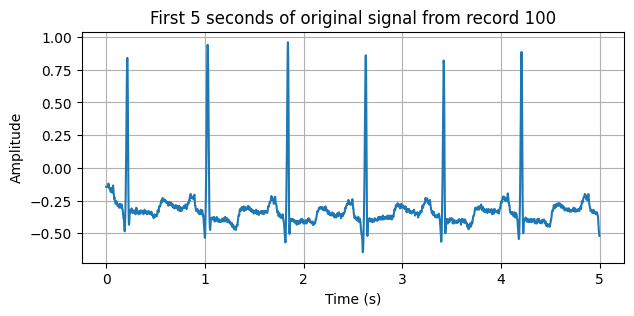

In [ ]:
import matplotlib.pyplot as plt

filtered_signal = ecg_signals['231']

# Calculate the number of samples for 5 seconds
fs = 360
num_samples = 5 * fs

# Create a time vector
time = [i/fs for i in range(num_samples)]

# Plot the first 5 seconds of the filtered signal
plt.figure(figsize=(7, 3))
plt.plot(time, filtered_signal[:num_samples, 0])
plt.title('First 5 seconds of original signal from record 100')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


# 2- ECG Signals filtering

## 2.1- Moving Average

In [ ]:
import numpy as np

def moving_average(signal, window_size):
    # Create a one-dimensional window
    window = np.ones(int(window_size))/float(window_size)

    # Convolve the signal with the window
    smoothed_signal = np.convolve(signal, window, 'same')

    return smoothed_signal

# Define the window size for the moving average filter
window_size = 3

# Apply the moving average filter to each record in the ECG signals dictionary
smoothed_ecg_signals = {}
for record, signal in ecg_signals.items():
    smoothed_signal1 = moving_average(signal[:, 0], window_size)
    smoothed_signal2 = moving_average(signal[:, 1], window_size)
    smoothed_ecg_signals[record] = np.column_stack((smoothed_signal1, smoothed_signal2))


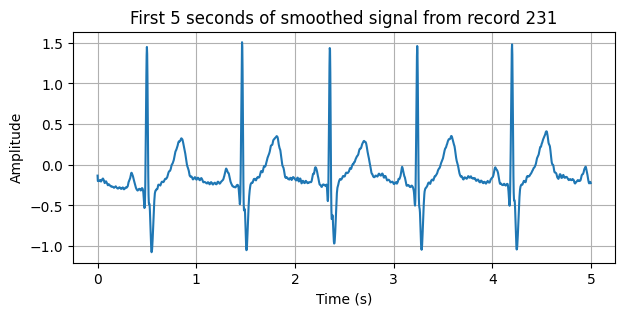

In [ ]:
record_name = '231'
filtered_signal = smoothed_ecg_signals[record_name]

# Calculate the number of samples for 5 seconds
fs = 360
num_samples = 5 * fs

# Create a time vector
time = [i/fs for i in range(num_samples)]

# Plot the first 5 seconds of the filtered signal
plt.figure(figsize=(7, 3))
plt.plot(time, filtered_signal[:num_samples, 0])
plt.title(f'First 5 seconds of smoothed signal from record {record_name}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


## 2.2- Butterworth Lowpass

In [ ]:
from scipy.signal import butter, filtfilt

N = 3 # Order of filter
Wn = 25  # Cutoff frequency in Hz

# Create the Butterworth filter
b, a = butter(N, Wn, fs=360, btype='low', analog=False)

# Apply the filter to each record in the ECG signals dictionary
filtered_signals = {}
for record, signal in smoothed_ecg_signals.items():
    filtered_signal = filtfilt(b, a, signal, axis=0)
    filtered_signals[record] = filtered_signal


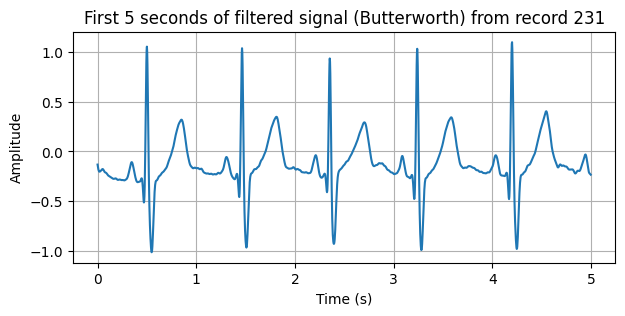

In [ ]:
record_name = '231'
filtered_signal = filtered_signals[record_name]

# Calculate the number of samples for 5 seconds
fs = 360
num_samples = 5 * fs

# Create a time vector
time = [i/fs for i in range(num_samples)]

# Plot the first 5 seconds of the filtered signal
plt.figure(figsize=(7, 3))
plt.plot(time, filtered_signal[:num_samples, 0])
plt.title(f'First 5 seconds of filtered signal (Butterworth) from record {record_name}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


## 2.3- Median

In [ ]:
import scipy.signal

filtered_2_signals = {}
# Define the kernel size for the median filter
kernel_size = 1

# Apply the median filter to each ECG signal
for record_name, signal in filtered_signals.items():
    filtered_2_signals[record_name] = scipy.signal.medfilt(signal, kernel_size)


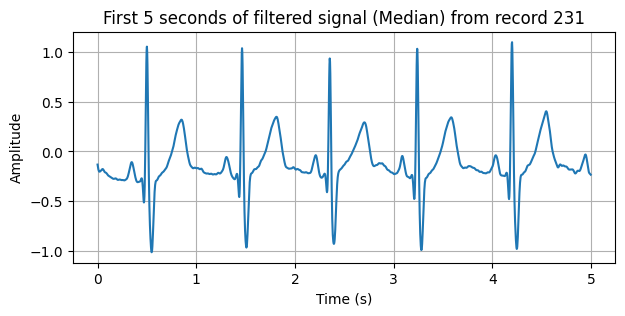

In [ ]:
record_name = '231'
filtered_signal = filtered_2_signals[record_name]

# Calculate the number of samples for 5 seconds
fs = 360
num_samples = 5 * fs

# Create a time vector
time = [i/fs for i in range(num_samples)]

# Plot the first 5 seconds of the filtered signal
plt.figure(figsize=(7, 3))
plt.plot(time, filtered_signal[:num_samples, 0])
plt.title(f'First 5 seconds of filtered signal (Median) from record {record_name}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

## 2.4- Normalization

In [ ]:
normalized_signals = {}

for record_name, signal in filtered_signals.items():
    normalized_signal_lead1 = (signal[:, 0] - np.min(signal[:, 0])) / (np.max(signal[:, 0]) - np.min(signal[:, 0])) * 2 - 1
    normalized_signal_lead2 = (signal[:, 1] - np.min(signal[:, 1])) / (np.max(signal[:, 1]) - np.min(signal[:, 1])) * 2 - 1

    normalized_signal = np.column_stack((normalized_signal_lead1, normalized_signal_lead2))
    normalized_signals[record_name] = normalized_signal


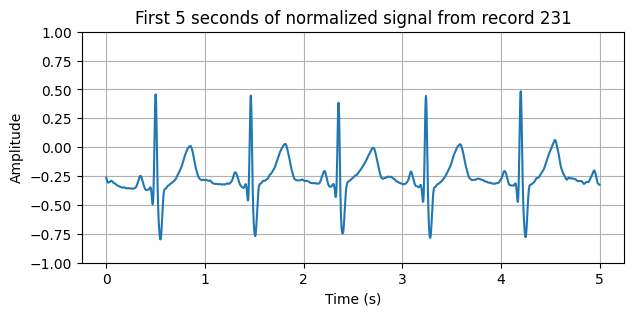

In [ ]:
record_name = '231'
filtered_signal = normalized_signals[record_name]

# Calculate the number of samples for 5 seconds
fs = 360
num_samples = 5 * fs

# Create a time vector
time = [i/fs for i in range(num_samples)]

# Plot the first 5 seconds of the filtered signal
plt.figure(figsize=(7, 3))
plt.plot(time, filtered_signal[:num_samples, 0])
plt.title(f'First 5 seconds of normalized signal from record {record_name}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.ylim(-1, 1)
plt.show()

# 3- Upload & Filter Annotations (eleminate non-beat annotations)

In [ ]:
# Get the annotations objects
def get_annotations(data_dir, records):
    annotations = {}
    for record_name in records:
        annotation = wfdb.rdann(os.path.join(data_dir, record_name), 'atr')
        annotations[record_name] = annotation
    return annotations

def filter_annotations(annotations, wanted_symbols):
    filtered_annotations = {}
    for record_name in annotations:
        record_annotations = annotations[record_name]
        filtered_record_annotations = []
        filtered_samples = []
        filtered_aux_notes = []
        for i, symbol in enumerate(record_annotations.symbol):
            if symbol in wanted_symbols:
                filtered_record_annotations.append(symbol)
                filtered_samples.append(record_annotations.sample[i])
                filtered_aux_notes.append(record_annotations.aux_note[i])
        # Create a new Annotation object with filtered symbols, samples, and aux_notes
        filtered_annotation = wfdb.Annotation(record_name=record_annotations.record_name,
                                              extension=record_annotations.extension,
                                              sample=filtered_samples,
                                              symbol=filtered_record_annotations,
                                              aux_note=filtered_aux_notes)
        filtered_annotations[record_name] = filtered_annotation
    return filtered_annotations


beat_ann = ['N', 'L', 'R', 'A', 'a', 'J', 'S', 'V', 'F', 'e', 'j', 'E', '/', 'f', 'Q']

annotations = get_annotations(data_dir, records)
f_annotations = filter_annotations(annotations, beat_ann)

# 4- ECG Signals Segmentation

In [ ]:
def segment_ecg_signals(ecg_signals, annotations):
    segmented_ecg_signals = {}
    for record_name in ecg_signals:
        signal = ecg_signals[record_name]
        annotation = annotations[record_name]
        segments = []
        for loc in annotation.sample:
            start = max(0, loc - 60)
            end = min(len(signal), loc + 90)
            segment = signal[start:end]
            segments.append(segment)
        segmented_ecg_signals[record_name] = segments
    return segmented_ecg_signals

segmented_beats = segment_ecg_signals(normalized_signals, f_annotations)

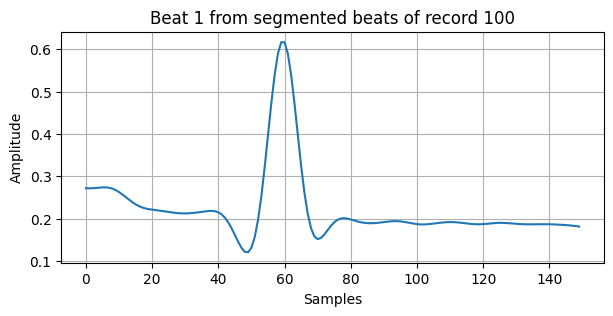

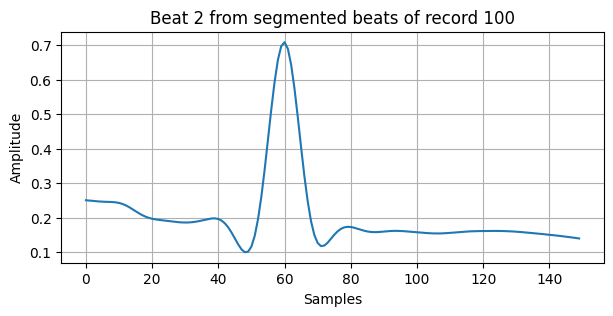

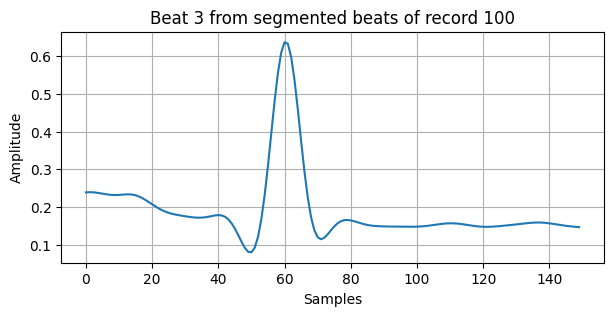

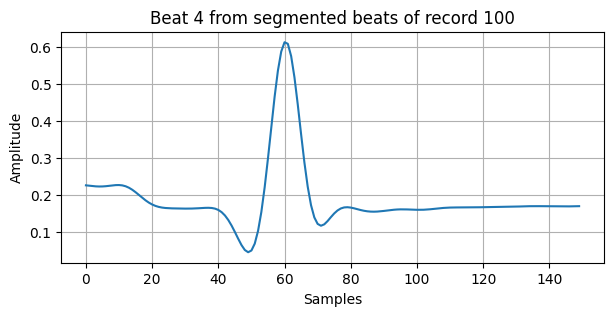

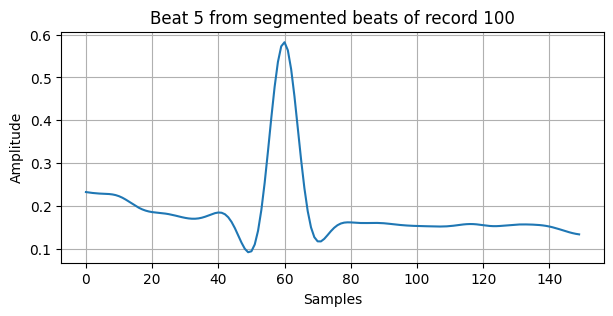

In [ ]:
record_name = '100'
# Get the signal for record
segmented_beat = segmented_beats[record_name]

# Calculate the number of samples for 5 seconds
fs = 360
num_samples = 4 * fs

# Get the first 5 seconds of the normalized signal
filtered_segment = {record_name: signal[:num_samples] for record_name, signal in normalized_signals.items()}

# Create a time vector
time = [i/fs for i in range(num_samples)]

# Plot the first 5 beats of the segmented beats
for i in range(5):
    plt.figure(figsize=(7, 3))
    plt.plot(segmented_beat[i][:, 0])
    plt.title(f'Beat {i+1} from segmented beats of record {record_name}')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

In [ ]:
# Get the annotations symbols
annotations = {}
for record_name in records:
    annotation = f_annotations[record_name]
    annotations[record_name] = annotation.symbol


In [ ]:
# Check for compatibility error between beats and annotations
for record_name in records:
        if record_name in segmented_beats and record_name in annotations:
          assert len(segmented_beats[record_name]) == len(annotations[record_name]), f"Mismatch in record {record_name}"


# 5- Filter Arrythmia Classes (6 classes for this project)

In [ ]:
# Filter for specific arrhythmia classes
def filter_beats(segmented_beats, annotations, wanted_symbols):
    filtered_beats = {}
    for record_name in segmented_beats.keys():
        if record_name in annotations:
            record_annotations = annotations[record_name]
            record_beats = segmented_beats[record_name]
            filtered_record_beats = [beat for beat, symbol in zip(record_beats, record_annotations) if symbol in wanted_symbols]
            filtered_beats[record_name] = filtered_record_beats
    return filtered_beats

def filter_annotations(segmented_beats, annotations, wanted_symbols):
    filtered_annotations = {}
    for record_name in segmented_beats.keys():
        if record_name in annotations:
            record_annotations = annotations[record_name]
            record_beats = segmented_beats[record_name]
            filtered_record_annotations = [symbol for beat, symbol in zip(record_beats, record_annotations) if symbol in wanted_symbols]
            filtered_annotations[record_name] = filtered_record_annotations
    return filtered_annotations

wanted_symbols = ['N', 'L', 'R', 'A', 'V', '/']

up_segmented_beats = filter_beats(segmented_beats, annotations, wanted_symbols)
up_annotations = filter_annotations(segmented_beats, annotations, wanted_symbols)


# 6- Process and split data for the training

## 6.1- Create a Pandas Dataframe

In [ ]:
# Flatten data
X = [up_segmented_beats[key] for key in sorted(up_segmented_beats.keys())]
y = [up_annotations[key] for key in sorted(up_annotations.keys())]

# Initialize two empty lists to hold the separated leads
X_lead1 = []
X_lead2 = []

for heartbeat in X:
    # Initialize two empty lists to hold the separated beats for this heartbeat
    heartbeat_lead1 = []
    heartbeat_lead2 = []

    for beat in heartbeat:
        # Separate the two leads and add them to their respective lists
        lead1, lead2 = beat[:, 0], beat[:, 1]
        heartbeat_lead1.append(lead1)
        heartbeat_lead2.append(lead2)

    # Add the separated beats for this heartbeat to X_lead1 and X_lead2
    X_lead1.append(heartbeat_lead1)
    X_lead2.append(heartbeat_lead2)

import pandas as pd

# Flatten the lists of heartbeats
X_lead1_flattened = [beat for heartbeat in X_lead1 for beat in heartbeat]
X_lead2_flattened = [beat for heartbeat in X_lead2 for beat in heartbeat]

# Flatten the list of annotations
y_flattened = [annotation for annotations in y for annotation in annotations]

# Create a DataFrame
df = pd.DataFrame({
    'lead1': X_lead1_flattened,
    'lead2': X_lead2_flattened,
    'annotation': y_flattened
})
df

,lead1,lead2,annotation
0,"[0.2719623283676629, 0.27168213953008724, 0.27...","[0.3802150619752045, 0.3811096823960034, 0.381...",N
1,"[0.2502050098797055, 0.2494641641841724, 0.248...","[0.30740536630197735, 0.30769189911034456, 0.3...",N
2,"[0.23922301962858095, 0.23978233229999923, 0.2...","[0.3038333146577661, 0.306046948714332, 0.3083...",N
3,"[0.22482148283160974, 0.2238099413569994, 0.22...","[0.3051362969620668, 0.3076232047139582, 0.310...",N
4,"[0.23238860483318824, 0.23130580502369447, 0.2...","[0.3001514911480059, 0.3015303075887641, 0.302...",N
...,...,...,...
107085,"[-0.09768047057491969, -0.09492529404655436, -...","[0.32330345769450997, 0.32806271007631227, 0.3...",N
107086,"[-0.09686170710374642, -0.09368912928706308, -...","[0.37629445158521824, 0.3848271757046722, 0.39...",N
107087,"[-0.11511947230002573, -0.111882607154561, -0....","[0.35213271495019915, 0.35573832260747684, 0.3...",N
107088,"[-0.10303472879112152, -0.09994733579094928, -...","[0.32308233000513153, 0.3236019000936208, 0.32...",N


## 6.2- Apply Data Augmentation (for class 'A')


In [ ]:
class_counts_before = df['annotation'].value_counts()
class_counts_before

annotation
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
Name: count, dtype: int64

In [ ]:
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd

# Define your function
def noise_injection(signal, noise_factor, fs, artifact_freqs):
    # Create a time array
    t = np.arange(len(signal)) / fs

    # Create a noise signal that contains the artifact frequencies
    noise = np.zeros_like(t)
    for f in artifact_freqs:
        noise += np.sin(2 * np.pi * f * t)

    # Add the noise to the original signal
    return [num + noise_factor * noise[i] for i, num in enumerate(signal)]

artifacts = [0.167, 0.090, 0.083, 0.042]

def time_warping(signal, sampling_rate=360):
    stretch_factor = np.random.uniform(0.3, 0.7)
    old_indices = np.arange(0, len(signal))
    new_length = int(len(signal) * stretch_factor)
    new_indices = np.linspace(0, len(signal)-1, new_length)
    interpolator = interp1d(old_indices, signal, kind='cubic')
    return list(interpolator(new_indices))


def amplitude_scaling(signal):
    scale_factor = np.random.uniform(0.4, 1.2)
    return [num * scale_factor for num in signal]

# Identify the minority class
minority_classes = ['A']

# Create a new DataFrame to hold the modified instances
df_modified = pd.DataFrame(columns=df.columns)

# Loop over the minority classes
for minority_class in minority_classes:
  # Apply the functions to the instances of the current minority class and add them to df_modified
  for i in df[df['annotation'] == minority_class].index:
      modified_lead1 = noise_injection(time_warping(amplitude_scaling(df.at[i, 'lead1'])), 0.02, 360, artifacts)
      modified_lead2 = noise_injection(time_warping(amplitude_scaling(df.at[i, 'lead2'])), 0.02, 360, artifacts)
      df_modified = pd.concat([df_modified, pd.DataFrame({'lead1': [modified_lead1], 'lead2': [modified_lead2], 'annotation': [df.at[i, 'annotation']]})], ignore_index=True)

# Append df_modified to the original DataFrame
df = pd.concat([df, df_modified], ignore_index=True)

In [ ]:
class_counts_after = df['annotation'].value_counts()

print(f"Class counts before data augmentation:\n{class_counts_before}\n")
print(f"Class counts after data augmentation:\n{class_counts_after}")

Class counts before data augmentation:
annotation
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
Name: count, dtype: int64

Class counts after data augmentation:
annotation
N    75052
L     8075
R     7259
V     7130
/     7028
A     5092
Name: count, dtype: int64


## 6.3- Convert Data to 3D NumPy Arrays


In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convert the lists of arrays into lists of lists
X_lead1_lists = df['lead1'].to_list()
X_lead2_lists = df['lead2'].to_list()

# Pad the lists of lists
X_lead1_padded = pad_sequences(X_lead1_lists, dtype='float32', padding='post')
X_lead2_padded = pad_sequences(X_lead2_lists, dtype='float32', padding='post')

# Convert the padded lists of lists into 3D numpy arrays
X_lead1 = np.array(X_lead1_padded)
X_lead2 = np.array(X_lead2_padded)


# Stack lead1 and lead2 along the last dimension
X = np.stack((X_lead1, X_lead2), axis=-1)


## 6.4- Annotations encoding (categorical to numerical)

In [ ]:
# Convert the annotations into numerical vectors
encoder = LabelEncoder()
y = to_categorical(encoder.fit_transform(df['annotation']))

## 6.5- Split Data to Train & Test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 7- Models Training & Validation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense
from tensorflow.keras.layers import GRU, Dense, Input
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
from tensorflow.keras.layers import LeakyReLU

model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(256, kernel_size=3, activation=LeakyReLU(negative_slope=0.01)),
    MaxPooling1D(pool_size=2),

    Bidirectional(GRU(128, return_sequences=True)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation=LeakyReLU(negative_slope=0.01)),
    Dense(y_train.shape[1], activation='softmax')
    ])

model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(X_train, y_train, epochs=20, batch_size=1000, validation_split=0.1)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.7953 - loss: 0.6451 - val_accuracy: 0.9712 - val_loss: 0.1326
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.9726 - loss: 0.1158 - val_accuracy: 0.9777 - val_loss: 0.0894
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.9780 - loss: 0.0879 - val_accuracy: 0.9804 - val_loss: 0.0762
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.9825 - loss: 0.0686 - val_accuracy: 0.9860 - val_loss: 0.0592
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.9832 - loss: 0.0617 - val_accuracy: 0.9863 - val_loss: 0.0586
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.9860 - loss: 0.0538 - val_accuracy: 0.9880 - val_loss: 0.0602
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.9872 - loss: 0.0481 - val_accuracy: 0.9886 - val_loss: 0.0511
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.9887 - loss: 0.0421 - val_accura

In [ ]:
model.evaluate(X_test, y_test)

686/686 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9924 - loss: 0.0388


[0.041478823870420456, 0.9910616278648376]

In [ ]:
model.save('ArrhythClassModel.h5')

NameError: name 'model' is not defined

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/ArrhythClassModel.h5')

TypeError: Error when deserializing class 'Conv1D' using config={'name': 'conv1d_1', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3], 'strides': [1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1], 'groups': 1, 'activation': {'module': 'keras.layers', 'class_name': 'LeakyReLU', 'config': {'name': 'leaky_re_lu_2', 'trainable': True, 'dtype': 'float32', 'negative_slope': 0.01}, 'registered_name': None, 'build_config': {'input_shape': [None, 148, 256]}}, 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}.

Exception encountered: Could not interpret activation function identifier: {'module': 'keras.layers', 'class_name': 'LeakyReLU', 'config': {'name': 'leaky_re_lu_2', 'trainable': True, 'dtype': 'float32', 'negative_slope': 0.01}, 'registered_name': None, 'build_config': {'input_shape': [None, 148, 256]}}

In [ ]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 score: {f1}")

686/686 [==============================] - 59s 83ms/step
F1 score: 0.9907857508828976


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.990879241152864
Precision: 0.9907939498118287
Recall: 0.990879241152864


686/686 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step
686/686 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
686/686 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
686/686 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
686/686 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
686/686 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


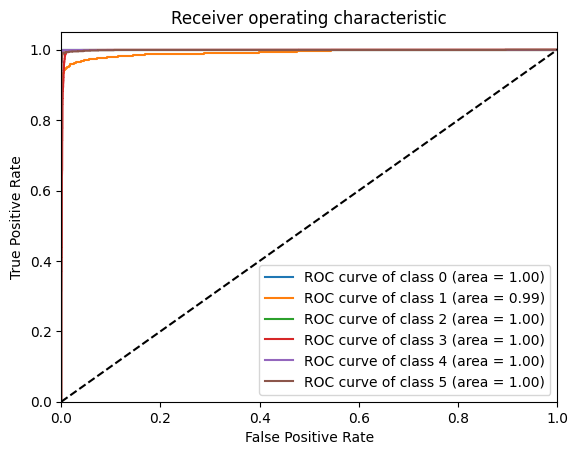

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_test.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], model.predict(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
import matplotlib.pyplot as plt

plt.figure()
for i in range(y_test.shape[1]):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:

y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)

y_true = y_test
y_true = np.argmax(y_true, axis=1)


686/686 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


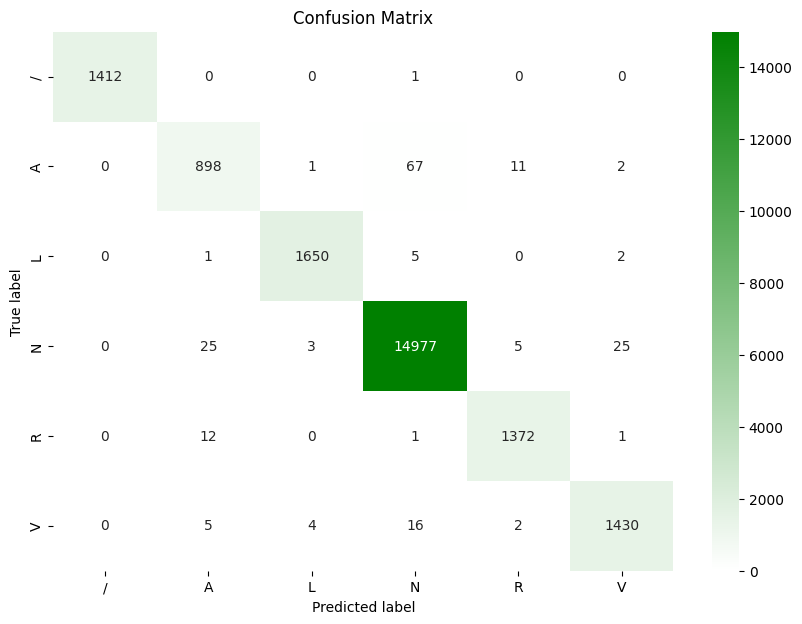

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.colors import LinearSegmentedColormap

# Convert encoded labels back to original values
y_true_labels = encoder.inverse_transform(y_true)
y_pred_labels = encoder.inverse_transform(y_pred)

# Calculate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=encoder.classes_)

# Convert confusion matrix to DataFrame for easier plotting
cm_df = pd.DataFrame(cm, index=encoder.classes_, columns=encoder.classes_)

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list('custom', ['white', 'green'], 256)

# Plot confusion matrix with the custom colormap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='g', cmap=cmap)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Generate the classification report
cr = classification_report(y_true_labels, y_pred_labels)

# Print the classification report
print("Classification Report:")
print(cr)

Classification Report:
              precision    recall  f1-score   support

           /       1.00      1.00      1.00      1395
           A       0.91      0.82      0.86       475
           L       1.00      0.99      1.00      1568
           N       0.99      1.00      0.99     15136
           R       0.98      0.99      0.99      1462
           V       0.98      0.98      0.98      1382

    accuracy                           0.99     21418
   macro avg       0.98      0.96      0.97     21418
weighted avg       0.99      0.99      0.99     21418



In [ ]:
class_names = {
    0: 'Paced beats',
    1: 'Atrial Premature beats',
    2: 'Left Bundle Branch Block beats',
    3: 'Normal beats',
    4: 'Right Bundle Branch Block beats',
    5: 'Premature ventricular contraction',
    6: 'Unclassifiable beats'
}